# Age Estimation and Gender Classification

Training CNN models to estimate a person's age and gender by given a face image.

**Tasks**

Training two CNN models:
- one is defined and trained from scratch
- the other a pretrained model that is finetuned

**Dataset**

The models will be trained and validated on a folder containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

## Setting Up: Mount the google drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualizing a few photos


'Total number of files in the folder: 5000


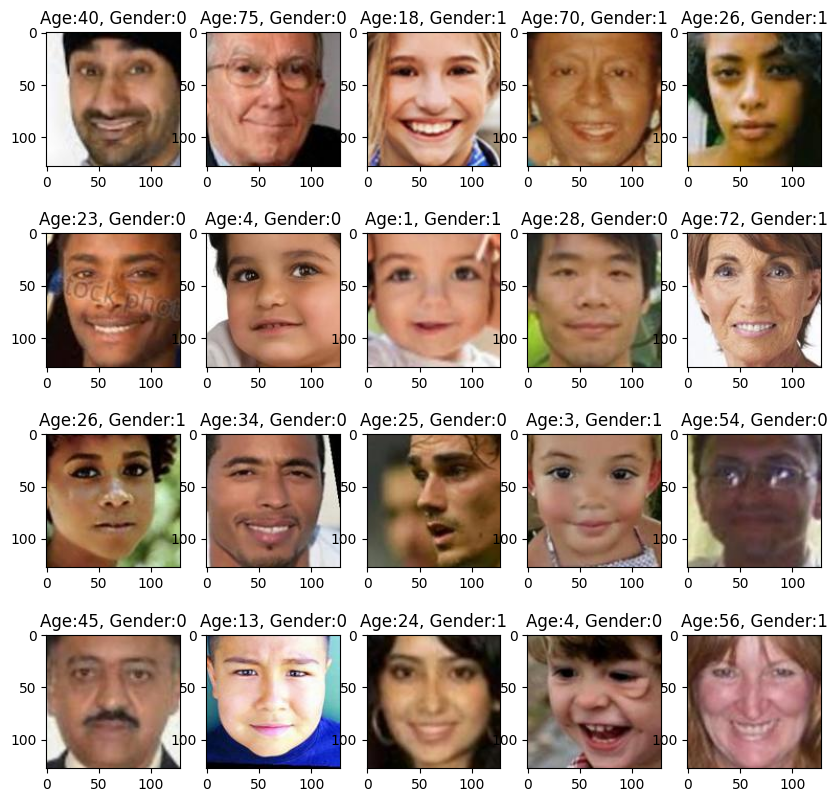

In [14]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

folder = '/content/drive/MyDrive/Colab Notebooks/age_gender/train_val/'

files = os.listdir(folder)

# Check files count
file_count = len([f for f in files if os.path.isfile(os.path.join(folder, f))])
print("'Total number of files in the folder: %i" %(file_count))

# Visualize 20 photos
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    filename = os.path.join(folder, files[i])
    if not os.path.exists(filename):
      print ('No such file:'+filename)

    # Extract information from filename
    file_name_only = os.path.basename(files[i])
    file_name_parts = file_name_only.split('_')

    age = file_name_parts[0]  # First part is age
    gender = file_name_parts[1]  # Second part is gender

    image = imread(filename)
    plt.imshow(image)
    # Display age and gender as the title for each subplot
    plt.title(f'Age:{age}, Gender:{gender}')
plt.show()

## Rearranging the dataset



                             image_names  ages  genders
0  40_0_3_20170119183403621.jpg.chip.jpg  40.0      0.0
1  75_0_0_20170117174511134.jpg.chip.jpg  75.0      0.0
2  18_1_0_20170109213011914.jpg.chip.jpg  18.0      1.0
3  70_1_3_20170116224931319.jpg.chip.jpg  70.0      1.0
4  26_1_1_20170116232602440.jpg.chip.jpg  26.0      1.0 



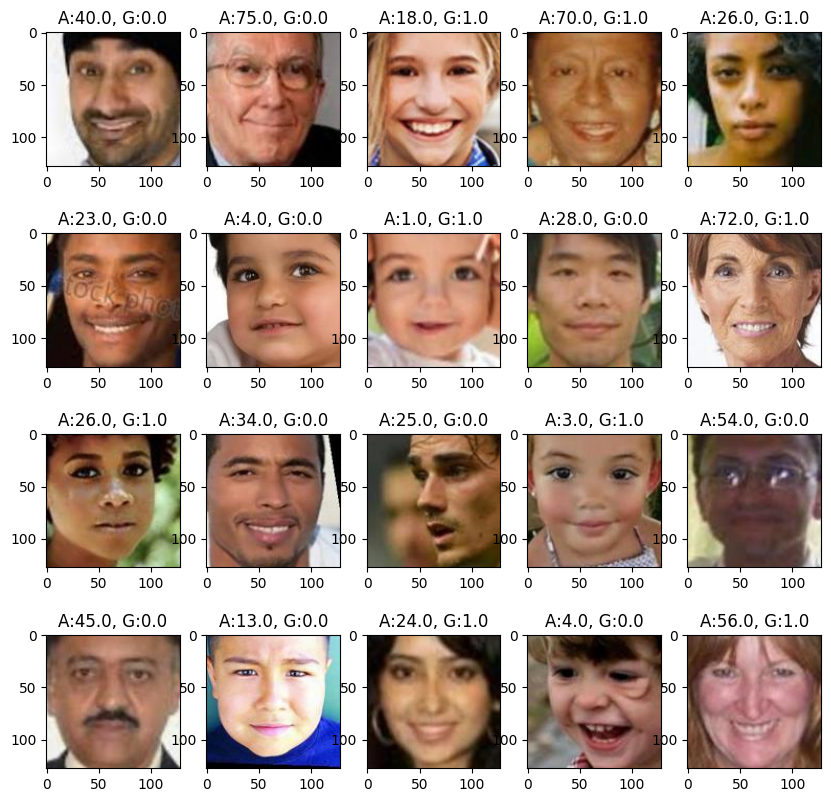

In [25]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Extracting labels from filenames
ages = []
genders = []
image_names = []

# Append images and labels into corresponding arrays
for file in files:
    # Extract age and gender from the filename
    image_names.append(file)
    file_parts = file.split('_')
    age = file_parts[0]  # First part is age
    gender = file_parts[1] # Second part is gender
    ages.append(age)
    genders.append(gender)

ages = np.array(ages, dtype=np.float32)
genders = np.array(genders, dtype=np.float32)

# Append the data in the form of a data dictionarypr
data = {
    'image_names': image_names,
    'ages': ages,
    'genders': genders
}

# Convert the list into a DataFrame and print first 5 rows
train_df = pd.DataFrame(data)
print(train_df.head(), '\n')

# Visualize 20 photos again to check data arrangement
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    filename = os.path.join(folder, files[i])
    if not os.path.exists(filename):
      print ('No such file:'+filename)

    image = imread(filename)
    plt.imshow(image)
    # Display age and gender as title for each subplot
    plt.title(f'A:{str(ages[i])}, G:{str(genders[i])}')
plt.show()

## STEP1: Data pre-processing

1.	Rescaling the pixel values (integers between 0 and 255) to [0,1]. 
2.	Data augmentation.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating an ImageDataGenerator to augment the images
# Also splitting training/validation data to 80%/20%
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)

# Validation data should not be augmented, only rescaled
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
)

batch_size = 32

# Creating the generator that will read pictures
# of training data, and generate batches of training image data
# (Training images flowing through the augmentation generator)

train_generator=train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = folder,
    x_col = 'image_names',
    y_col = ['ages', 'genders'],
    target_size = (128, 128),
    batch_size = batch_size,
    class_mode ="multi_output",
    shuffle = True,
    subset = "training",
)

val_generator=train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = folder,
    x_col = 'image_names',
    y_col = ['ages', 'genders'],
    target_size = (128, 128),
    batch_size = batch_size,
    class_mode = "multi_output",
    shuffle = False,
    subset = "validation",
)

# Checking number of training/validation images
print("Number of training images: ", train_generator.n)
print("Number of validation images: ", val_generator.n)

Found 4000 validated image filenames.
Found 1000 validated image filenames.
Number of training images:  4000
Number of validation images:  1000


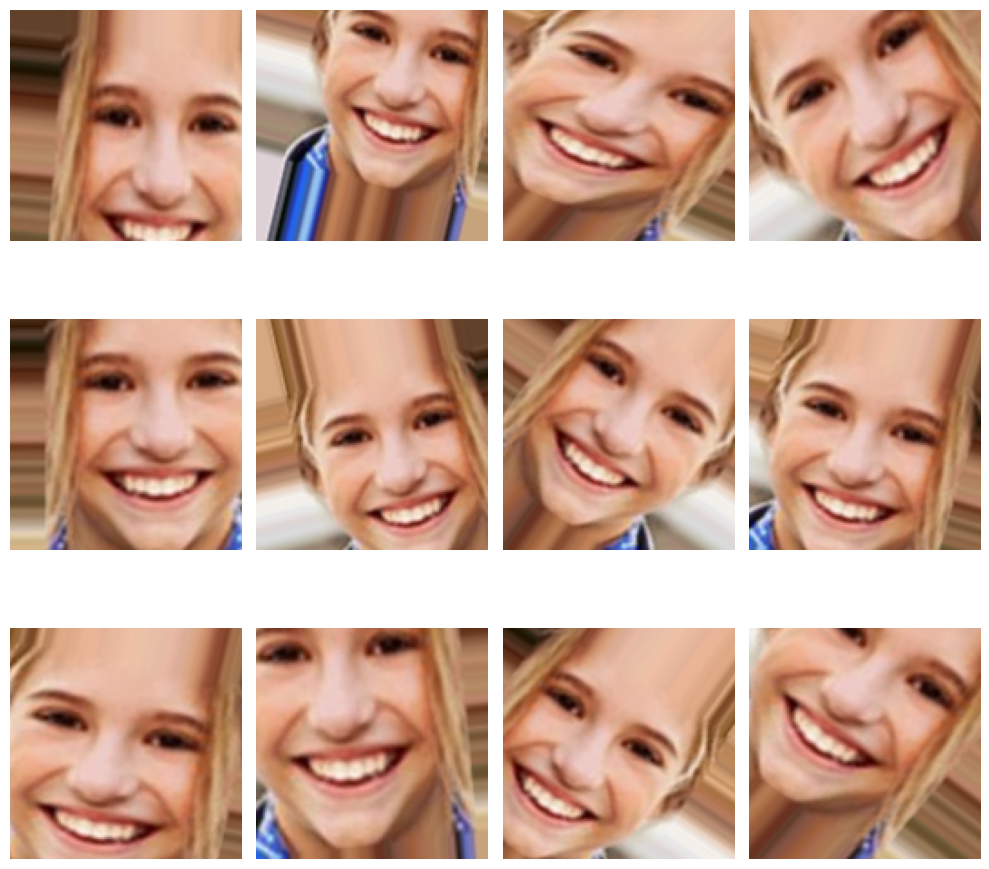

In [17]:
# Checking some augmented images

from tensorflow.keras.preprocessing import image

# Choose a random image from the dataset (second one)
img_path = os.path.join(folder, files[2])
img = image.load_img(img_path, target_size=(128, 128))

# Change the image to a np array and reshape it for the generator
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0 # Counter

# Plotting the augmented images
plt.figure(figsize=(10, 10))

# Generate augmented images
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.tight_layout()
plt.show()

## STEP2A: Building a CNN network

Defining a multi-output CNN for classifying the gender and predicting the age. 

1. Treating gender classification as a binary problem.
2. Batch Normalization and Dropout used as techniques for preventing overfitting
3. Standard 3x3 filters with no padding and default straddle
4. Plotting the model's architecture

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (32, 128, 128, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (32, 128, 128, 32)     │            896 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (32, 128, 128, 32)     │            128 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (32, 64, 64, 32)       │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (32, 64, 64, 64)       │         18,496 │ max_pooling2d_41[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (32, 64, 64, 64)       │            256 │ conv2d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_42          │ (32, 32, 32, 64)       │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (32, 32, 32, 128)      │         73,856 │ max_pooling2d_42[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (32, 32, 32, 128)      │            512 │ conv2d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_43          │ (32, 16, 16, 128)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (32, 16, 16, 256)      │        295,168 │ max_pooling2d_43[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (32, 16, 16, 256)      │          1,024 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_44          │ (32, 8, 8, 256)        │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (32, 8, 8, 512)        │      1,180,160 │ max_pooling2d_44[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (32, 8, 8, 512)        │          2,048 │ conv2d_45[0][0]        │
│ (BatchNormalization) 

 Total params: 33,577,666 (128.09 MB)

 Trainable params: 33,569,538 (128.06 MB)

 Non-trainable params: 8,128 (31.75 KB)

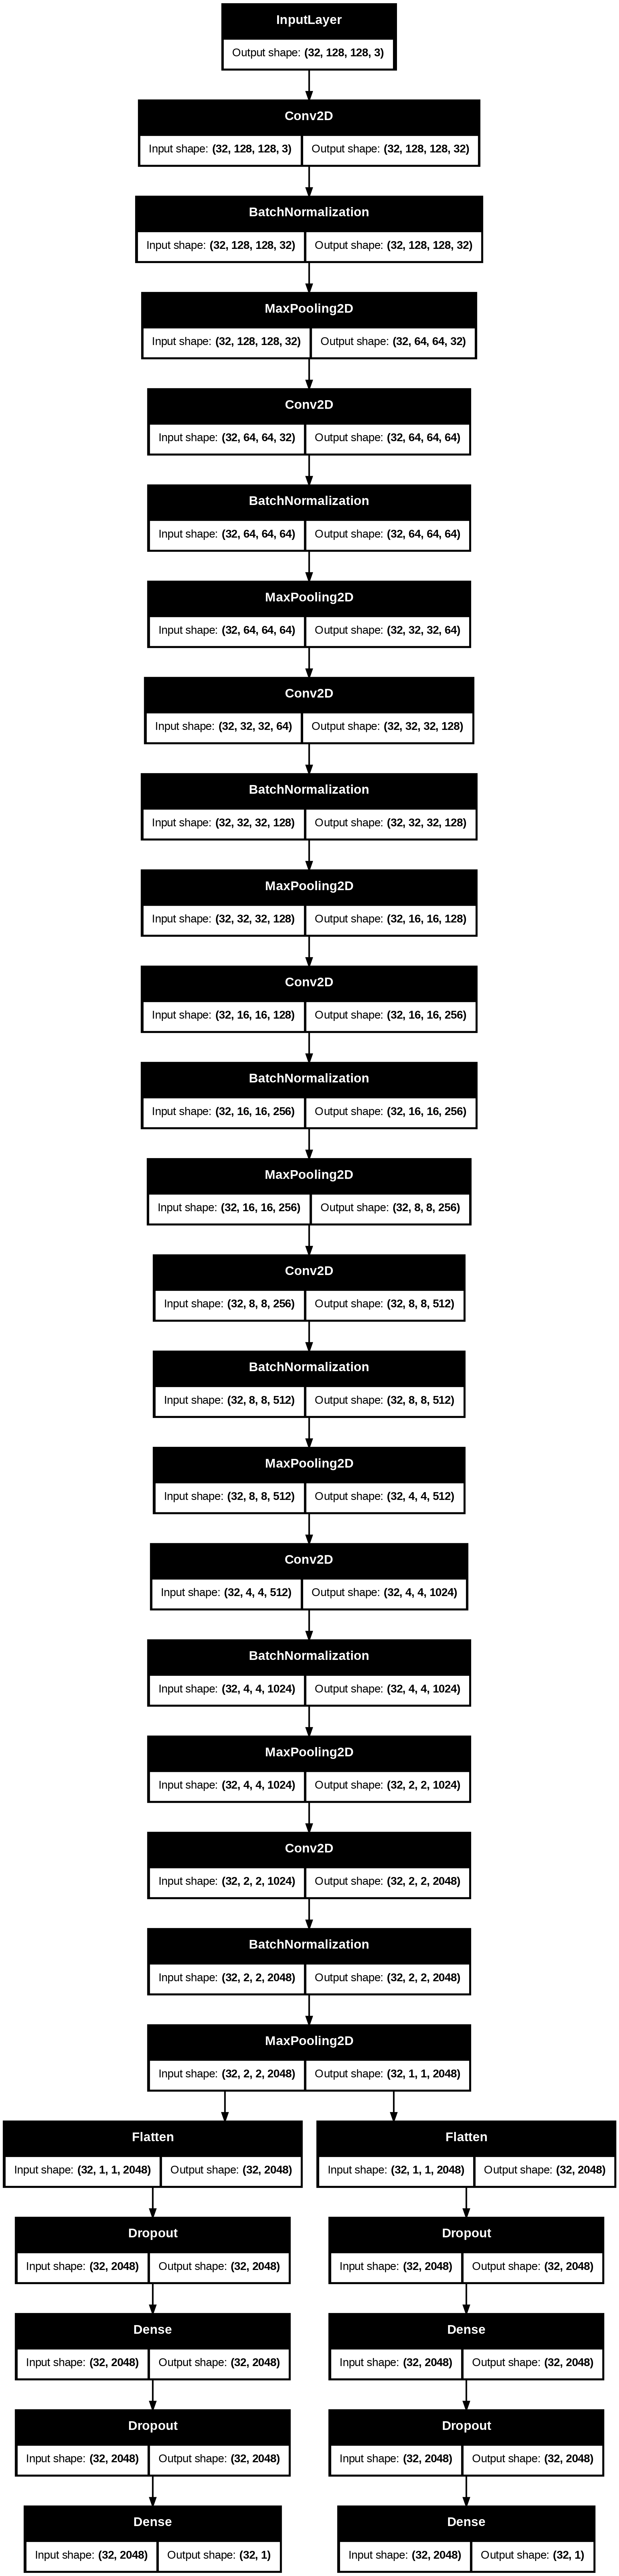

In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#Input layer with input shape
inputs = Input(shape=(128, 128, 3), batch_size = batch_size)

# Convolutational layers for feature extraction incorporating batch normalization
# after every conv layer to prevent overfitting
# standard 3x3 filters are used with no padding and default straddle
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
bnorm1 = BatchNormalization()(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(bnorm1)

conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(maxpool1)
bnorm2 = BatchNormalization()(conv2)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(bnorm2)

conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(maxpool2)
bnorm3 = BatchNormalization()(conv3)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(bnorm3)

conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(maxpool3)
bnorm4 = BatchNormalization()(conv4)
maxpool4 = MaxPooling2D(pool_size=(2, 2))(bnorm4)

conv5 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(maxpool4)
bnorm5 = BatchNormalization()(conv5)
maxpool5 = MaxPooling2D(pool_size=(2, 2))(bnorm5)

conv6 = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(maxpool5)
bnorm6 = BatchNormalization()(conv6)
maxpool6 = MaxPooling2D(pool_size=(2, 2))(bnorm6)

# The final convolutional layer ensures the feature map is less than 10x10
conv7 = Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same')(maxpool6)
bnorm7 = BatchNormalization()(conv7)
maxpool7 = MaxPooling2D(pool_size=(2, 2))(bnorm7)

# Age fully connected layers
# incoporating dropout of 0.4 after every Dense layer to prevent overfitting
age_flatten = Flatten()(maxpool7)
age_final = Dropout(0.4)(age_flatten)
age_final = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(age_final)
age_final = Dropout(0.4)(age_final)
age_final = Dense(1, activation='relu', name='age')(age_final)

# Gender fully connected layers
# incoporating dropout of 0.4 after every Dense layer to prevent overfitting
gender_flatten = Flatten()(maxpool7)
gender_final = Dropout(0.4)(gender_flatten)
gender_final = Dense(2048, activation='relu')(gender_final)
gender_final = Dropout(0.4)(gender_final)
gender_final = Dense(1, activation='sigmoid', name='gender')(gender_final)

# Defining modelA with two outputs
modelA = Model(inputs=inputs, outputs=[age_final,gender_final])

# Model Summary
modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compiling and training model
Compiling, training and saving the model.

In [36]:
import numpy as np

# Generator wrapper function to conver the multi_output to np array so that
# the data can be used for training
def generator_wrapper(generator):
    """Wraps the existing generator to convert the output to NumPy arrays."""
    for x, y in generator:
        y_gender = np.array(y[0])  # Gender output
        y_age = np.array(y[1])      # Age output
        yield x, (y_gender, y_age)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
import keras

# Compile the model
modelA.compile(optimizer = 'adam',
              loss = {'age': 'mean_squared_error', 'gender': 'binary_crossentropy'},
              metrics = {'age': 'mae', 'gender': 'accuracy'}
)

# Wrap the train and validation generators using the generator wrapper
train_gen = generator_wrapper(train_generator)
val_gen = generator_wrapper(val_generator)

# SNumber of steps for both the training and validation
train_steps = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size

# Training the model
# Using early stopping with patience 15 epochs to prevent overfitting
history = modelA.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=150
)
# Save the model
your_model_folder = '/content/drive/MyDrive/Colab Notebooks/age_gender_models'
import os
if not os.path.exists(your_model_folder):
    os.mkdir(your_model_folder)
modelA.save(your_model_folder+'/age_gender_A.h5')

Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 333ms/step - age_mae: 18.4614 - gender_accuracy: 0.5590 - loss: 596.6207 - val_age_mae: 15.8069 - val_gender_accuracy: 0.5351 - val_loss: 434.9123
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 320ms/step - age_mae: 13.9807 - gender_accuracy: 0.5932 - loss: 329.3132 - val_age_mae: 17.5706 - val_gender_accuracy: 0.5423 - val_loss: 521.3742
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 329ms/step - age_mae: 12.6690 - gender_accuracy: 0.6224 - loss: 271.7765 - val_age_mae: 18.0549 - val_gender_accuracy: 0.5083 - val_loss: 554.9131
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 304ms/step - age_mae: 12.7386 - gender_accuracy: 0.6160 - loss: 282.4833 - val_age_mae: 12.7536 - val_gender_accuracy: 0.6715 - val_loss: 294.4539
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - age_mae: 11.7036 - gender_accuracy: 0.6226 - loss: 249.9366 - val_age_mae: 24.4892 - val_gender_accuracy: 0.5713 - val_loss: 814.4947
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━

## STEP4A: Drawing the learning curves
Drawing figures as follows
1.	Overall loss of the gender classification and age estimation over the training and validation sets
2.	The accuracy of the gender classification over the training and validation set
3.	The MAE of the age estimation over the training and validation set


dict_keys(['age_mae', 'gender_accuracy', 'loss', 'val_age_mae', 'val_gender_accuracy', 'val_loss'])


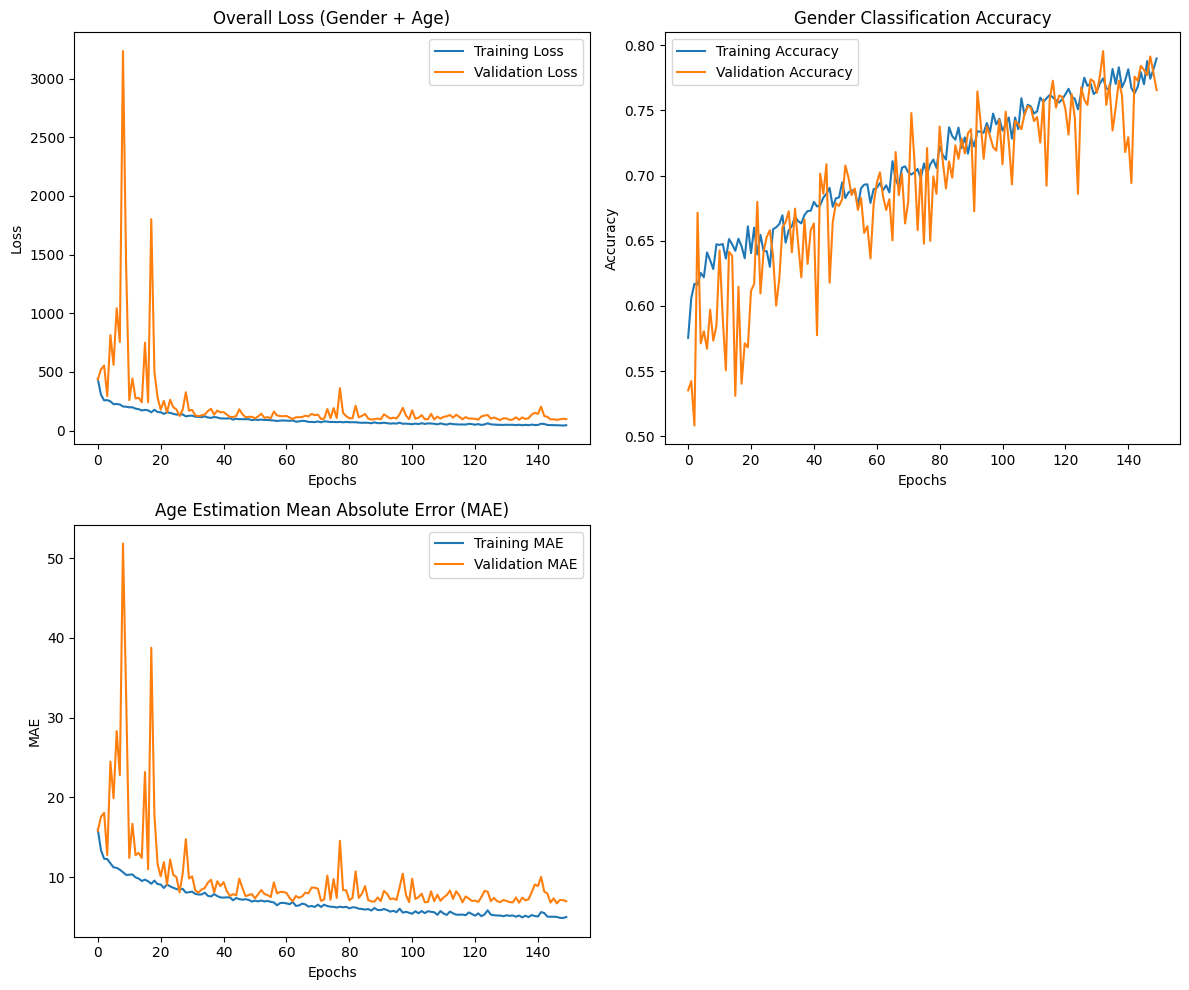

In [42]:
print(history.history.keys())
plt.figure(figsize=(12, 10))

# Current version on Google colab, keras or tensorflow
# does not allow me to distinct the two separate
# loss values for age and gender despite the fact that I have correctly
# initialized and defined them in the compile() function
# A probable cause is the generator wrapper needed to convert multi_output
# Therefore, we look at total loss only

# Plot 1: Total loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Overall Loss (Gender + Age)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Gender classification accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['gender_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Validation Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot 4: Age estimation MAE
plt.subplot(2, 2, 3)
plt.plot(history.history['age_mae'], label='Training MAE')
plt.plot(history.history['val_age_mae'], label='Validation MAE')
plt.title('Age Estimation Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## STEP2B: Building a CNN network based on a pre-trained model
Using VGG16 as the base pre-trained model, and fine-tuning it on this dataset.


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 48,277,314 (184.16 MB)

 Trainable params: 40,642,050 (155.04 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

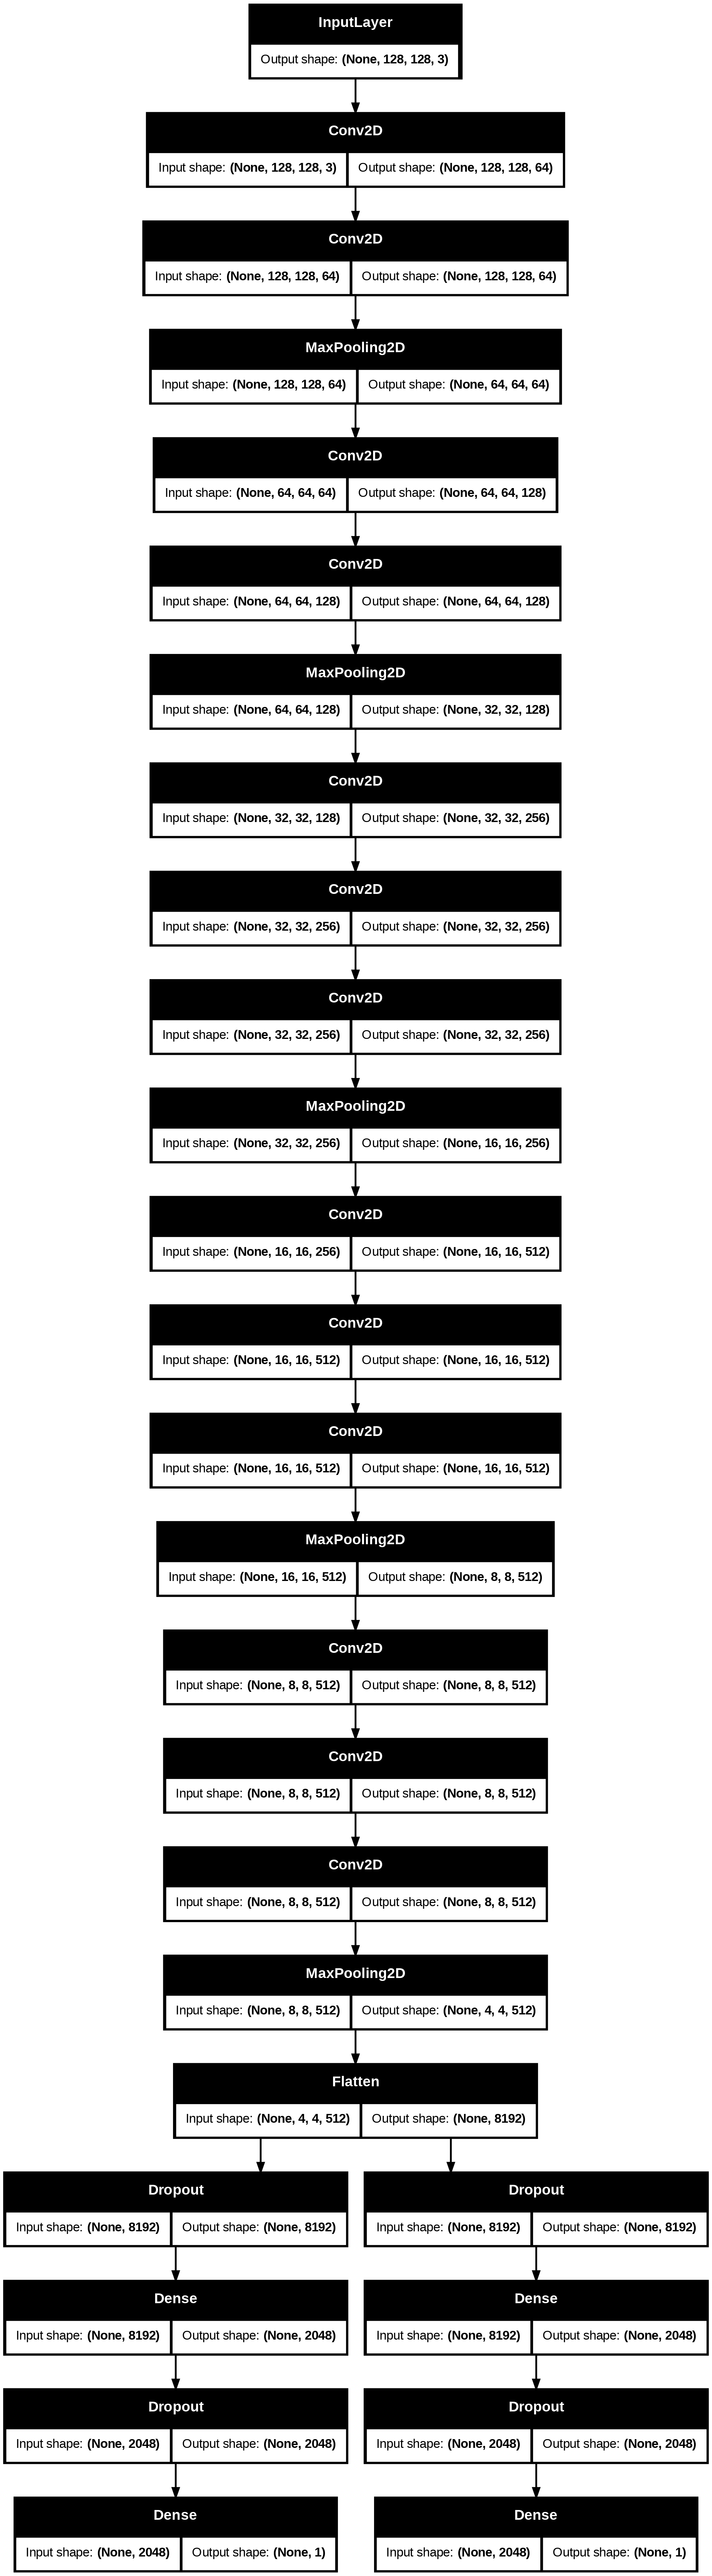

In [56]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Loading VGG16 model without the last fully connected layers
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(128, 128, 3))

# Freeze all the layers initially
for layer in base_model.layers:
    layer.trainable = False

# Fine tuning the CNN by training the last block of convolutional layers
# Empirically produces better results on accuracy and mae
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
  if layer.name.startswith('block5_conv'):
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

# Adding layers on top of the base model to fit the task
flattenB = Flatten()(base_model.output)

# Age fully connected layers
age_finalB = Dropout(0.4)(flattenB)
age_finalB = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(age_finalB)
age_finalB = Dropout(0.4)(age_finalB)
age_finalB = Dense(1, activation='relu', name='age')(age_finalB)

# Gender fully connected layers
gender_finalB = Dropout(0.4)(flattenB)
gender_finalB = Dense(2048, activation='relu')(gender_finalB)
gender_finalB = Dropout(0.4)(gender_finalB)
gender_finalB = Dense(1, activation='sigmoid', name='gender')(gender_finalB)

# Defining modelB with two outputs
modelB = Model(inputs=base_model.input, outputs=[age_finalB, gender_finalB])

# Model Summary
modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compiling and training model
Compiling, training and saving the model.


In [57]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Compile model with low learning rate to effectively train convolutional layers
# This is important when fine-tuning
modelB.compile(optimizer=Adam(learning_rate=0.0001),
               loss={'age': 'mean_squared_error', 'gender': 'binary_crossentropy'},
               metrics={'age': 'mae', 'gender': 'accuracy'})

historyB = modelB.fit(
      train_gen,
      steps_per_epoch=train_steps,
      validation_data=val_gen,
      validation_steps=val_steps,
      epochs=150
)

your_model_folder = '/content/drive/MyDrive/Colab Notebooks/age_gender_models'
import os
if not os.path.exists(your_model_folder):
    os.mkdir(your_model_folder)
modelB.save(your_model_folder+'/age_gender_B.h5')

Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 508ms/step - age_mae: 14.4448 - gender_accuracy: 0.5842 - loss: 373.2267 - val_age_mae: 10.5672 - val_gender_accuracy: 0.6983 - val_loss: 185.6480
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 561ms/step - age_mae: 9.5442 - gender_accuracy: 0.6730 - loss: 168.0412 - val_age_mae: 8.9595 - val_gender_accuracy: 0.7252 - val_loss: 150.2004
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 453ms/step - age_mae: 8.9121 - gender_accuracy: 0.6981 - loss: 148.9622 - val_age_mae: 8.7182 - val_gender_accuracy: 0.7490 - val_loss: 141.4748
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 500ms/step - age_mae: 8.6913 - gender_accuracy: 0.7101 - loss: 142.1055 - val_age_mae: 8.3433 - val_gender_accuracy: 0.7228 - val_loss: 132.0178
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - age_mae: 8.3065 - gender_accuracy: 0.7224 - loss: 131.2213 - val_age_mae: 8.0350 - val_gender_accuracy: 0.7262 - val_loss: 127.8508
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 423

## STEP4B: Drawing the learning curve

Drawing figures as follows

1. Overall loss of the gender classification and age estimation over the training and validation sets
2. The accuracy of the gender classification over the training and validation set
3. The MAE of the age estimation over the training and validation set

dict_keys(['age_mae', 'gender_accuracy', 'loss', 'val_age_mae', 'val_gender_accuracy', 'val_loss'])


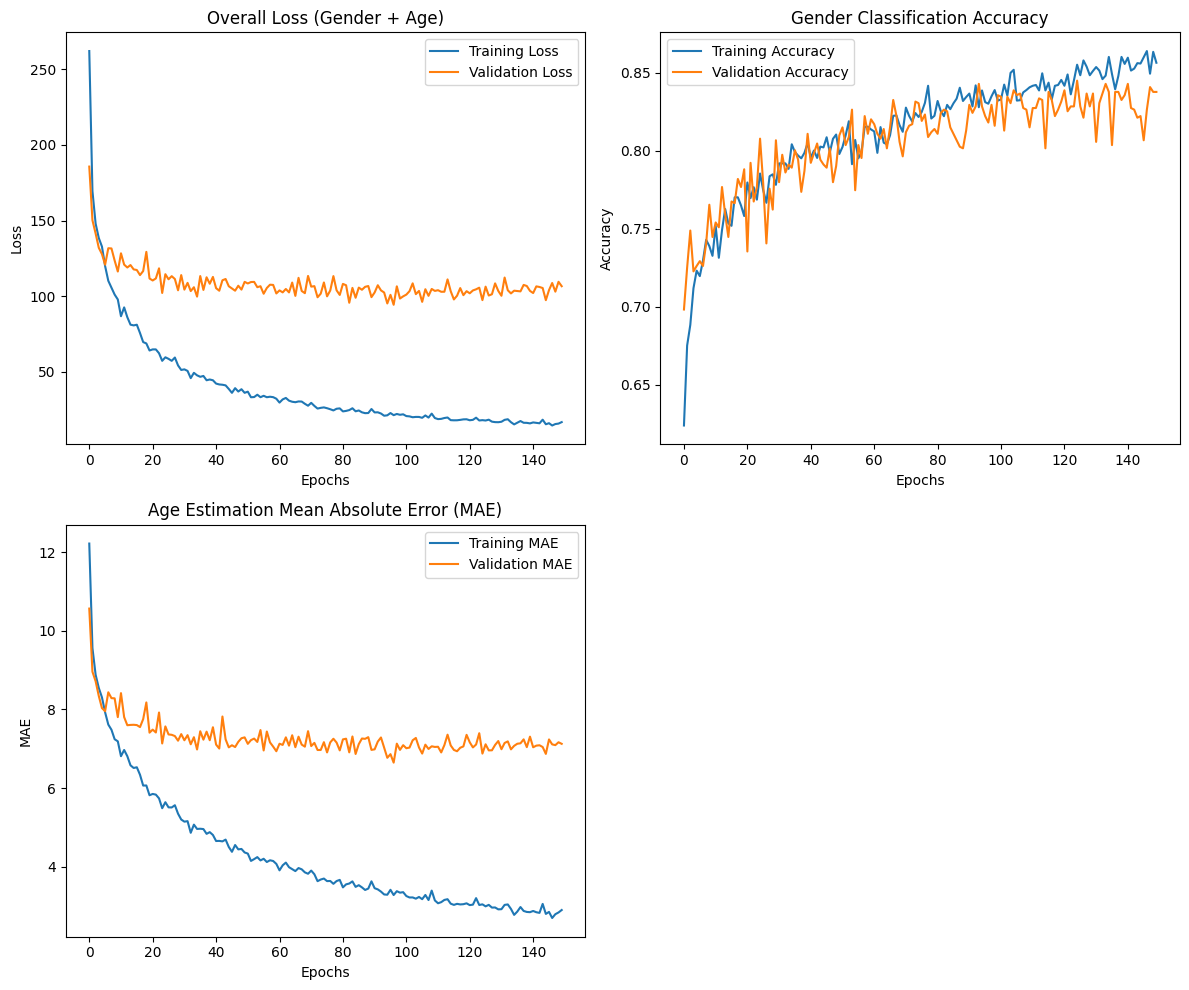

In [58]:
print(history.history.keys())
plt.figure(figsize=(12, 10))

# Current version on Google colab, keras or tensorflow
# does not allow me to distinct the two separate
# loss values for age and gender despite the fact that I have correctly
# initialized and defined them in the compile() function
# A probable cause is the generator wrapper needed to convert multi_output
# Therefore, we look at total loss only

# Plot 1: Total loss
plt.subplot(2, 2, 1)
plt.plot(historyB.history['loss'], label='Training Loss')
plt.plot(historyB.history['val_loss'], label='Validation Loss')
plt.title('Overall Loss (Gender + Age)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Gender classification accuracy
plt.subplot(2, 2, 2)
plt.plot(historyB.history['gender_accuracy'], label='Training Accuracy')
plt.plot(historyB.history['val_gender_accuracy'], label='Validation Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot 4: Age estimation MAE
plt.subplot(2, 2, 3)
plt.plot(historyB.history['age_mae'], label='Training MAE')
plt.plot(historyB.history['val_age_mae'], label='Validation MAE')
plt.title('Age Estimation Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()